Need to run to install `FEM on Colab` to use `fenics` package in notebook later. [Reference](https://fem-on-colab.github.io/packages.html). 

Might crash session in order to restart kernel. Just rerun cell and it should work.

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2023-06-09 00:25:13--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-06-09 00:25:13 (41.4 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/6895377/releases/pybind11-install.s

# Data Generation

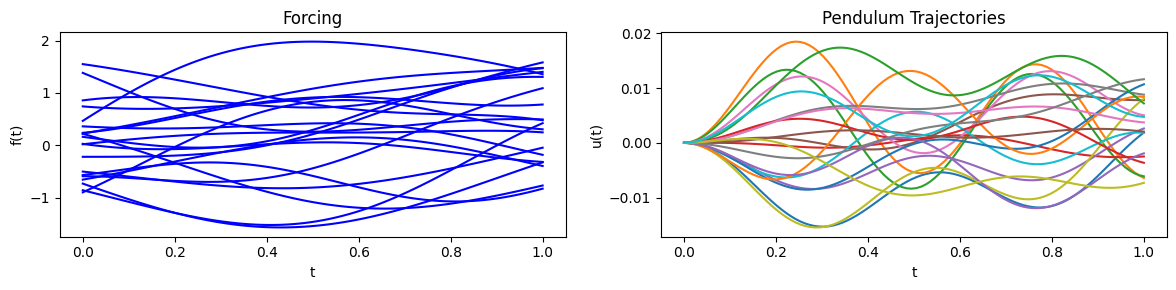

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.gaussian_process.kernels import RBF

# np.random.seed(1234)
# Define pendulum parameter k=g/L.
# Note: Set to be around 150ish for interesting dynamics.
k = 150

def build_pendulum_data(F, t, beta):
    """
    F = (I, J) array of desired forcing terms
    t = (J,) array of times of data collection
    beta = perturbation size
    
    Notes:
        - set beta equal to zero for the training data
        - assumes a zero initial condition
    """
    # Define the pendulum governing equations.
    def pendulum(t, y, k, i, beta):
        u1, u2 = y
        f = lambda t: F[i, int(t / dt)] + (beta * np.sin(5 * np.pi * t))
        return [u2, -(k * np.sin(u1)) + f(t)]

    # Define the pendulum traectories.
    U = np.empty(F.shape)
    for i in range(len(F)):
        sol = solve_ivp(
            pendulum,
            t_span=(t[0], t[-1]),
            y0=(0, 0),
            t_eval=t,
            args=(k, i, beta),
        )
        U[i] = sol.y[0]

    return U

I = 20 # number of trajectories to consider
J = 100 # number of time points to consider

# Define time points between t=0 and t=1.
t = np.linspace(0, 1, J)
dt = t[1] - t[0]

# Define the forcing terms f via a Gaussian Process.
rbf = RBF(length_scale=0.5)
mean = np.zeros(len(t))
cov = rbf(t.reshape(-1, 1))
rng = np.random.default_rng(seed=24)
F = rng.multivariate_normal(mean, cov, size=I)
U = build_pendulum_data(F, t, beta=0)

# Plot forcing and pendulum trajectories.
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title("Forcing")
for i in range(I):
    plt.plot(t, F[i], c="b")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.subplot(1, 2, 2)
plt.title("Pendulum Trajectories")
for i in range(I):
    plt.plot(t, U[i])
plt.xlabel("t")
plt.ylabel("u(t)")
plt.tight_layout()
plt.show()

# Kernel Smoothing + Differentiation (eq.13,14)

In [ ]:
import jax.numpy as jnp
from jax import grad
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels

def kernel_smoothing(
    X, U, 
    kernel_metric="rbf",
    kernel_params={"gamma":3},
    _lambda=1e-8,
):
    """
    X = (J, N) array containing mesh observation points (i.e. assumes N-D grid).
    U = (J,) array of PDE solutions
    kernel_metric = kernel function to use
    kernel_params = dictionary of kernel parameters
    _lambda = assumed standard deviation of measurement noise
    """
    K = lambda x, y: pairwise_kernels(x, Y=y, metric=kernel_metric, **kernel_params)
    z = np.linalg.lstsq(K(X, X) + (_lambda**2) * np.eye(len(X)), U, rcond=None)[0]
    U_bar = lambda x: K(x, X).dot(z)
    return U_bar

# def kernel_diff(
#     X, U, d,
#     kernel_metric="rbf",
#     kernel_params={"gamma":3},
#     _lambda=1e-8,
# ):
#     """
#     d = order of derivative
#     Note: Only RBF kernel functionality is implemented...
#     """
#     Kxx = pairwise_kernels(X, Y=X, metric=kernel_metric, **kernel_params)
#     # print("Kxx shape:",Kxx.shape)
#     z = np.linalg.lstsq(Kxx + (_lambda**2) * np.eye(len(X)), U, rcond=None)[0].reshape(-1)
#     # print("z shape:",z.shape)
#     if kernel_metric == "rbf":
#         # K(x, y) = exp(-gamma||x-y||^2)
#         # vec = jnp.exp(-kernel_params["gamma"]*jnp.sum((x-X)**2,axis=1).reshape(-1,1))
#         # print("vec shape:", vec.shape)
#         u_bar = lambda x: jnp.array(z).dot(
#             jnp.exp(-kernel_params["gamma"]*jnp.sum((x-X)**2,axis=1).reshape(-1,1))
#             )[0]
#     else:
#         raise ValueError("Kernel method not supported for differentiation.")

#     du_bar = grad(u_bar)
#     for i in range(d - 1):
#         du_bar = grad(du_bar)

#     return du_bar

def kernel_diff(
    X, U, d,
    kernel_metric="rbf",
    kernel_params={"gamma":3},
    _lambda=1e-8,
):
    """
    d = order of derivative
    Note: Only RBF kernel functionality is implemented...
    """
    Kxx = pairwise_kernels(X, Y=X, metric=kernel_metric, **kernel_params)
    z = np.linalg.lstsq(Kxx + (_lambda**2) * np.eye(len(X)), U, rcond=None)[0].reshape(-1)
    if kernel_metric == "rbf":
        # K(x, y) = exp(-gamma||x-y||^2)
        u_bar = lambda x: jnp.array(z).dot(
            jnp.exp(-kernel_params["gamma"]*jnp.sum((x-X)**2,axis=1).reshape(-1,1))
        )[0]
    else:
        raise ValueError("Kernel method not supported for differentiation.")

    du_bar = grad(u_bar)
    for i in range(d - 1):
        du_bar = grad(du_bar)

    return du_bar

# Benchmarking: Kernel Smoothing + Differentiation
$$
u(x) = \sin(ax)
$$

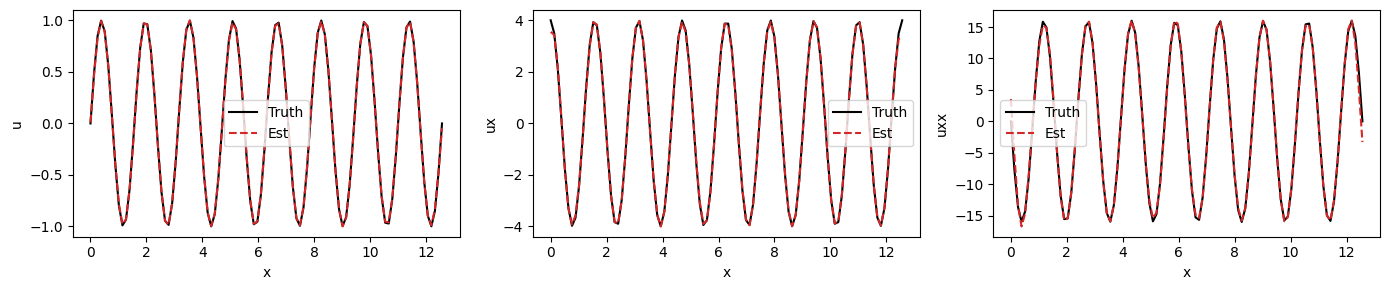

In [ ]:
# Evaluate true function values.
a = 4
x = np.linspace(0, 4 * np.pi, 100)
u_true = np.sin(a * x)
ux_true = a * np.cos(a * x)
uxx_true = -(a ** 2) * np.sin(a * x)

# Add noise to data?
noise_mag = 0.01
u_noisy = u_true + (noise_mag * np.random.randn(*u_true.shape))

# Get functions.
u_func = kernel_smoothing(x.reshape(-1, 1), u_noisy, _lambda =1e-1)
u_est = u_func(x[:, None])

ux_func = kernel_diff(x.reshape(-1, 1), u_est, d=1)
uxx_func = kernel_diff(x.reshape(-1, 1), u_est, d=2)

# Evaluate function values.
# u_est = u_func(x[:, None])
ux_est = np.array([ux_func(np.array(xi)) for xi in x])
# print(ux_est)
uxx_est = np.array([uxx_func(np.array(xi)) for xi in x])

# Plot the computed derivatives.
plt.figure(figsize=(14, 3))
for i, (truth, est, label) in enumerate(zip([u_true, ux_true, uxx_true], 
                                            [u_est, ux_est, uxx_est],
                                            ["u", "ux", "uxx"])):
    plt.subplot(1, 3, i + 1)
    plt.plot(x, truth, c="k", label="Truth")
    plt.plot(x, est, "--", c="tab:red", label="Est")
    plt.xlabel("x")
    plt.ylabel(label)
    plt.legend()

plt.tight_layout()
plt.show()

# Kernel Regression (eq.15)

In [ ]:
def kernel_regression(S, f, kernel_metric, kernel_params, _lambda, K = None):
    """
    S = (J, Jp) array of state variables
    f = (J,) array of corresponding PDE forcing terms
    kernel_metric = kernel function to use
    kernel_params = dictionary of kernel parameters
    _lambda = nugget parameter
    """
    if K is None:
      K = lambda x, y: pairwise_kernels(x, Y=y, metric=kernel_metric, **kernel_params)
    z = np.linalg.lstsq(K(S, S) + (_lambda**2)*np.eye(len(S)), f, rcond=None)[0]
    P = lambda s: K(s, S).dot(z)
    return P

# Benchmarking: Kernel Regression Function (eq. 15)

We will benchmark the `kernel_regression` function on the 1-dimension wave equation 
$$\frac{\partial^2 u}{\partial t^2} + k^2 u  =0 $$
which to be consistent with notation can be written in the form 
$$\mathcal{P}(s) = \mathbf{f}$$
where $s = (t, u, u_t, u_{tt})$, $\mathcal{P}(s)=\frac{\partial^2 u}{\partial t^2}$, and $\mathbf{f} = -k^2u $   (OR $\mathcal{P}(s)=-k^2u$, and $\mathbf{f} = \frac{\partial^2 u}{\partial t^2}$). 

The solution is $u(t) = A \cos(kt) + B \sin(kt)$ where we consider the points $t \in (0,1)$. 

In [ ]:
# I = 20 # number of trajectories to consider
# J = 100 # number of time points to consider

# # Define time points between t=0 and t=1.
# t = np.linspace(0, 1, J)

# # First example A = 1, B = 0, k=10
# A = 1
# B = 0
# k=10
# # print(t)

# # Define solution to wave equation (and respective derivatives)
# U_wave = A*np.cos(k*t) + B*np.sin(k*t)
# Ut_wave = -k*A*np.sin(k*t) + k*B*np.cos(k*t)
# Utt_wave = -k**2*A*np.cos(k*t)-k**2*B*np.sin(k*t)

# print(U_wave.shape)

# # Define forcing and S vectors
# F_wave = -k**2*U_wave
# S_wave = np.vstack([t, U_wave, Ut_wave, Utt_wave]).T
# # S_wave = np.vstack([t]).T

# # Regress PDE
# P_wave = kernel_regression(
#     S_wave,
#     F_wave,
#     kernel_metric="poly",
#     kernel_params={"gamma":1,"degree":3,"coef0":0.015},
#     _lambda=1e-5,
# )

# # Evaluate at collocation points
# P_approx = P_wave(S_wave)
# P_true = Utt_wave


# # Plot and evaluate results
# plt.plot(t,P_true, c="black", label='P true')
# plt.plot(t,P_approx, '--', c='r', label='P approx')
# plt.legend()

# L2_error = np.linalg.norm(P_approx - P_true) / np.linalg.norm(P_true)
# print(f"L2 Relative Error: {L2_error}")

# Apply to Pendulum Data!

In [ ]:
print(U.shape)
print(t.shape)

(20, 100)
(100,)


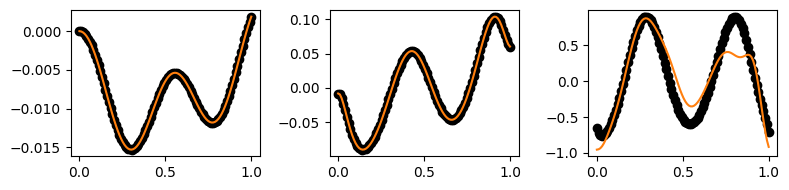

0.40229920765470756


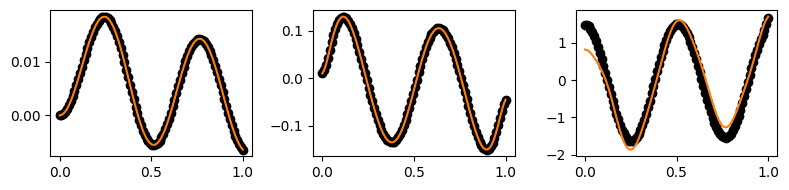

0.25887253014953515


KeyboardInterrupt: ignored

In [ ]:
for i, ui in enumerate(U):
    # ui = U[i] (pendulum trajectory with forcing term i)

    # Get smooth data.
    u1_func_smooth = kernel_smoothing(t[:, None], ui)
    u1_est = u1_func_smooth(t[:, None])

    # Get derivatives using smooth data.
    u2_func = kernel_diff(t[:, None], u1_est, d=1)
    u2_est = np.array([u2_func(np.array(tj)) for tj in t])

    u2_func_smooth = kernel_smoothing(t[:, None], u2_est)
    u2_est = u2_func_smooth(t[:, None])

    u3_func = kernel_diff(t[:, None], u1_est, d=2)
    # u3_func = kernel_diff(t[:, None], u2_est, d=1)
    u3_est = np.array([u3_func(np.array(tj)) for tj in t])
    u3_func_smooth = kernel_smoothing(t[:, None], u3_est, _lambda=1e-9)
    u3_est = u3_func_smooth(t[:, None])

    # Apply kernel regression.
    S = np.vstack([u1_est, u2_est]).T
    P1 = kernel_regression(
        S, u2_est,
        kernel_metric="poly",
        kernel_params={"gamma":1,"degree":3,"coef0":0.015}, _lambda=1e-4,
    )
    P2 = kernel_regression(
        S, u3_est,
        kernel_metric="poly",
        kernel_params={"gamma":1,"degree":3,"coef0":0.01}, _lambda=1e-4,
    )

    # P2_true = Fs[i] - (k*np.sin(u1_est))
    # plt.figure(figsize=(8, 2))
    # plt.subplot(1, 3, 1)
    # plt.plot(ts, ui[2:], "-o", c="k")
    # plt.plot(ts, u1_est, c="tab:orange")
    # plt.subplot(1, 3, 2)
    # plt.plot(ts, u2_est, "-o", c="k")
    # plt.plot(ts, P1(S), c="tab:orange")
    # plt.subplot(1, 3, 3)
    # # plt.plot(ts, P2_true, "-o", c="k")
    # plt.plot(ts, u3_est, "-o", c="k")
    # plt.plot(ts, P2(S), c="tab:orange")
    # plt.tight_layout()
    # plt.show()
    # print(np.linalg.norm(P2(S) - P2_true) / np.linalg.norm(P2_true))

    P2_true = F[i] - (k*np.sin(u1_est))
    plt.figure(figsize=(8, 2))
    plt.subplot(1, 3, 1)
    plt.plot(t, ui, "-o", c="k")
    plt.plot(t, u1_est, c="tab:orange")
    plt.subplot(1, 3, 2)
    plt.plot(t, u2_est, "-o", c="k")
    plt.plot(t, P1(S), c="tab:orange")
    plt.subplot(1, 3, 3)
    # plt.plot(ts, P2_true, "-o", c="k")
    plt.plot(t, u3_est, "-o", c="k")
    plt.plot(t, P2(S), c="tab:orange")
    plt.tight_layout()
    plt.show()
    print(np.linalg.norm(P2(S) - P2_true) / np.linalg.norm(P2_true))

In [ ]:
# Data for testing:
F_test = np.random.multivariate_normal(mean, cov, size=I)
U_test = build_pendulum_data(F_test, t, beta=0.8)

# Apply to Darcy Flow!

We have the following pde subject to homogenous Dirichlet boundary conditions
$$-\text{div}(a \nabla u)(x) = f(x), \quad x \in \Omega = (0,1)^2,$$
$$u = 0, \quad x \in \partial \Omega,$$
 Where the coefficient $a$ is spatially variable given by 

$$a(x) = e^{\sin(\pi x_1) + \sin(\pi x_2)} + e^{-\sin(\pi x_1)-\sin(\pi x_2)}.$$

The forcing term $f$ is drawn from a Gaussian Process.

Expanding the Darcy equation:
$$-\text{div}(a \nabla u)(x) = f(x)$$
$$-\text{div}(a \langle u_{x_1}, u_{x_2} \rangle)(x) = f(x)$$
$$-[(a u_{x_1})_{x_1}+ (au_{x_2})_{x_2} ](x) = f(x)$$
$$- [a_{x_1}u_{x_1}+a u_{x_1 x_1} + a_{x_2}u_{x_2} + a u_{x_2 x_2}](x) = f(x)$$
$$-[a_{x_1} u_{x_1} + a_{x_2} u_{x_2} + a \Delta u](x) = f(x)$$
Giving us
$$\bar{P}(x_1, x_2, u, u_{x_1}, u_{x_2}, \Delta u)= f(x) \qquad \text{where} \qquad P(x_1, x_2, u, u_{x_1}, u_{x_2}, \Delta u): = -[a_{x_1} u_{x_1} + a_{x_2} u_{x_2} + a \Delta u](x) $$

## Create functions to create and solve darcy flow pde

In [ ]:
# Spread my seed
import numpy as np
np.random.seed(12345)

In [ ]:
import numpy as np
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import tri
import fenics as fx

def generate_forcing(J, V, plot = False):
    ''' Generate forcing terms for DARCY FLOW on J by J grid,
     and convert onto Fenic function space V. '''
    # Define time points between t=0 and t=1dim.
    t = np.linspace(0, 1, J)
    dt = t[1] - t[0]
    t = t.reshape(-1,1)

    # Define the forcing terms f via a Gaussian Process.
    f_kernel = RBF(length_scale=0.2)
    mean = np.zeros(t.size)
    cov = f_kernel(t.reshape(-1, 1))
    forcing = np.empty((J, J))

    # Plot the forcing (see Figure 2 od Appendix B).
    forcing[:, 0] = np.random.multivariate_normal(mean, cov)
    forcing = np.tile(forcing[:, 0].reshape(-1, 1), (1, J))

    # Plot the output
    if plot:
        plt.figure(figsize=(5, 2))
        plt.imshow(forcing, interpolation='sinc')

    # Convert the numpy to fenic.
    # Flatten and assign the numpy data to the fenics_data Function
    fenics_data = fx.Function(V)
    fenics_data.vector()[:] = forcing.flatten() 
    return fenics_data

def evalute_darcy(griddim, plot = False):
    # Create mesh and define function space
    fx.parameters["reorder_dofs_serial"] = False # DO NOT FUCKING COMMENT THIS OUT YOU TWAT.
    mesh = fx.UnitSquareMesh(griddim, griddim)

    def non_shit_plot(u):
        u_projected = fx.project(u, V)
        # Create a triangulation from the mesh
        triangulation = tri.Triangulation(*mesh.coordinates().reshape((-1, 2)).T,
                                          triangles=mesh.cells())
        fig, ax = plt.subplots() 
        c = ax.tricontourf(triangulation, u_projected.vector(), cmap=cm.seismic)
        fig.colorbar(c)

    V = fx.FunctionSpace(mesh, "P", 1)

    # Define boundary condition
    u_D = fx.Constant(0)

    def boundary(x, on_boundary):
        return on_boundary

    bc = fx.DirichletBC(V, u_D, boundary)

    # Define variational problem
    u = fx.TrialFunction(V)
    v = fx.TestFunction(V)

    # Coefficient function (a in the paper)
    K = fx.Expression("exp(sin(pi*x[0]) + sin(pi*x[1])) + exp(-sin(pi*x[0]) - sin(pi*x[1]))", degree=2)

    forcing = generate_forcing(griddim+1, V, plot=plot)
    f = forcing

    if plot:
        plt.figure()
        K_projected = fx.project(K, V)
        plot(K_projected, title="K(x)")
        plt.show()

        plt.figure()
        forcing_projected = fx.project(forcing, V)
        plot(forcing_projected, title="forcing")
        plt.show()

    # Problem looks like
    # ∫Ω (K(x) ∇u ⋅ ∇v) dΩ = ∫Ω f * v dΩ
    a = K * fx.dot(fx.grad(u), fx.grad(v))*fx.dx
    L = f*v*fx.dx

    # Compute solution
    u = fx.Function(V)
    fx.solve(a == L, u, bc)

    # Convert FEniCS function to NumPy array
    u_array = u.compute_vertex_values(mesh)
    u_np = np.array(u_array).reshape((griddim+1, griddim+1))

    # Plot solution
    if plot:
        non_shit_plot(u)
        plt.show()

    return u_np, u, f

## Solve & generate Darcy Flow PDE data for $I$ forcing functions $f_i$.

Save numerical solutions at collcation points (sols). Functions for each solution $u_i$ and functions for each forcing $f_i$.

In [ ]:
I = 10
griddim = 15
sols = np.zeros((I, griddim+1, griddim+1))
sols_fun = [None for i in range(I)]
forcing_fun = [None for i in range(I)]

for i in range(I):
    print(f"{i} done.")
    sols[i], sols_fun[i], forcing_fun[i] = evalute_darcy(griddim)

with open("DARCY_This_Man_Turned_Himself_Into_A_PICKLE.npy", 'wb') as f:
    np.save(f, sols)

0 done.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00780725 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.263762 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_3a8881269f4d293e7424f1e63a4f4b275e0f854b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_8]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0577161 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00598764 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0456083 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00480986 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0162845 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ae27e007f037562d98139a57c511ec2941e9a049

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_7]'
  Unique elements:           'CG1(?,?), CG2(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), CG2(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0419345 seconds.

INFO:FFC:Compiler stage 2: 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_6ab56968c6ffa883272fd990bd40fad8bf858cca

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0101979 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0147061 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

1 done.
2 done.
3 done.
4 done.
5 done.
6 done.
7 done.
8 done.
9 done.


## Apply pipeline to one case of darcy flow. Just the firstin forcing $f_0$.

In [ ]:
i = 0
ui = sols[i,:,:]
fi = forcing_fun[i] 

In [ ]:
t = np.linspace(0,1,griddim+1)
print(t.shape)

# Might something with how I unravel Xi?
Xi = np.stack(np.meshgrid(t,t), axis=-1).reshape(-1,2)
print(Xi.shape)
Ui = ui.reshape(-1,1)

# Get first derivatives from gradient
Ui_grad_func = kernel_diff(Xi,Ui,d=1)

Ui_grad_est = np.array([np.array(Ui_grad_func(xi)) for xi in Xi])

Ui_x = Ui_grad_est[:,0]
Ui_y = Ui_grad_est[:,1]

# Get second derivatives
Ui_x_grad_func = kernel_diff(Xi,Ui_x,d=1)
Ui_y_grad_func = kernel_diff(Xi,Ui_y,d=1)

Ui_x_grad_est = np.array([np.array(Ui_x_grad_func(xi)) for xi in Xi])
Ui_y_grad_est = np.array([np.array(Ui_y_grad_func(xi)) for xi in Xi])

Ui_xx = Ui_x_grad_est[:,0]
Ui_yy = Ui_y_grad_est[:,1]

(16,)
(256, 2)


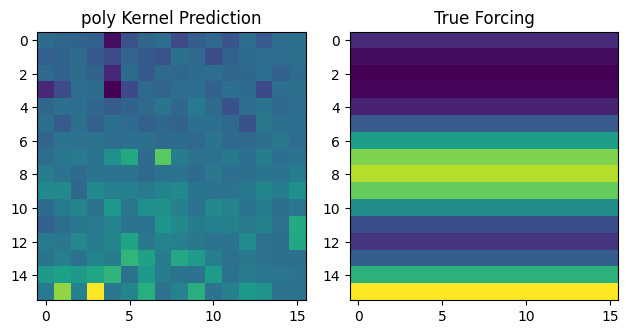

0.8870849552911115


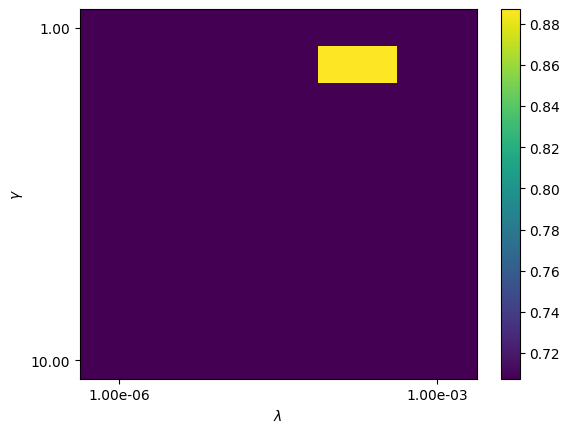

10.0 1e-06
1.0163885840415406e-12


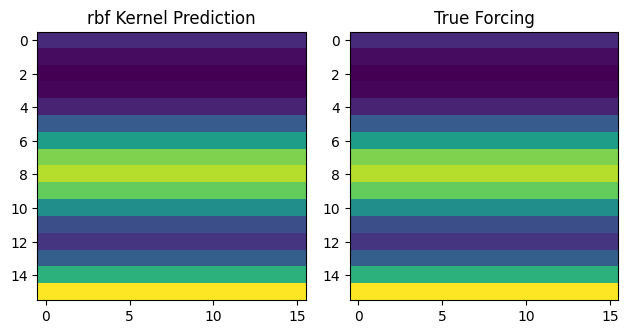

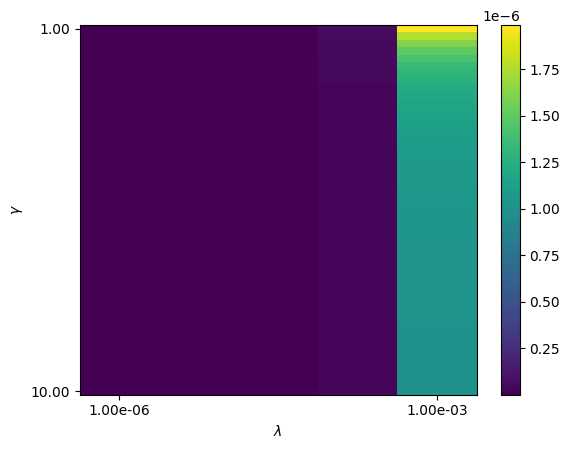

In [16]:
def eval_darcy_acc(kernel_metric, kernel_params, _lambda, plot=False):
  t = np.linspace(0,1,griddim+1)

  # Define forcing and S vectors
  F = np.array([fi(xi) for xi in Xi])
  S = np.vstack([Xi[:,0], Xi[:,1],Ui.reshape(-1,), Ui_x, Ui_y, Ui_xx, Ui_yy]).T
  
  P_darcy = kernel_regression(
      S,
      F,
      kernel_metric=kernel_metric,
      kernel_params=kernel_params,
      _lambda=_lambda,
  )

  # Evaluate at collocation points
  P_approx = P_darcy(S)
  P_true = F

  # Check L2 relative error
  L2_error = np.linalg.norm(P_approx - P_true) / np.linalg.norm(P_true)
  # print(f"L2 Relative Error: {L2_error}")
  # # print()


  # # Reshape the arrays
  if plot:
    P_approx_reshaped = P_approx.reshape(griddim + 1, griddim + 1)
    P_true_reshaped = P_true.reshape(griddim + 1, griddim + 1)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2)

    # Plot P_approx in the first subplot
    plt.subplot(1,2,1)
    plt.imshow(P_approx_reshaped)
    plt.title(f'{kernel_metric} Kernel Prediction')

    # Plot P_true in the second subplot
    plt.subplot(1,2,2)
    plt.imshow(P_true_reshaped)
    plt.title('True Forcing')
    # plt.suptitle(f'kernel = {kernel_metric}')

    # Adjust the layout
    plt.tight_layout()

    # Display the plot
    plt.show()

  return L2_error

def plot_grid(gammas, lambdas, grid):
  plt.imshow(grid, aspect='auto')
  plt.yticks([0, len(gammas)-1], [f'{p:.2f}' for p in [gammas[0], gammas[-1]]])
  plt.xticks([0, len(lambdas)-1], [f'{p:.2e}' for p in [lambdas[0], lambdas[-1]]])
  plt.ylabel('$\\gamma$')
  plt.xlabel('$\\lambda$')
  plt.colorbar()
  plt.show()

# Poly kernel sweep
gammas = np.linspace(1.0,10.0, 10)
lambdas = 10**np.linspace(-6.0, -3.0, 5)

grid = np.zeros((gammas.shape[0], lambdas.shape[0]), dtype=float)
for i, gamma in enumerate(gammas):
  for j, _lambda in enumerate(lambdas):
    grid[i,j] = eval_darcy_acc("poly", {"gamma":gamma,"degree":1,"coef0":0.08}, _lambda)

i, j = np.unravel_index(grid.argmin(), grid.shape)
grid[i,j] = eval_darcy_acc("poly", {"gamma":gammas[i]}, lambdas[j], plot=True)
print(grid[i, j])
plot_grid(gammas, lambdas, grid)

# RBF kernel sweep
gammas = np.linspace(1.0,10.0, 50)
lambdas = 10**np.linspace(-6.0, -3.0, 5)

grid = np.zeros((gammas.shape[0], lambdas.shape[0]), dtype=float)
for i, gamma in enumerate(gammas):
  for j, _lambda in enumerate(lambdas):
    grid[i,j] = eval_darcy_acc("rbf", {"gamma":gamma}, _lambda)

i, j = np.unravel_index(grid.argmin(), grid.shape)
print(gammas[i], lambdas[j])
print(grid[i, j])
grid[i,j] = eval_darcy_acc("rbf", {"gamma":gammas[i]}, lambdas[j], plot=True)
plot_grid(gammas, lambdas, grid)

## things to do 
1. tune hyper parameters
2. Modify `kernel_diff` (right now it only differentiates in one varaible)
- Actually I think 2 is fine now.